<a href="https://colab.research.google.com/github/jos0213/kaggle/blob/main/public_0_84627_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 모델 학습 및 평가
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불균형 문제 해결
from imblearn.over_sampling import SMOTE

# 머신러닝 모델
import lightgbm as lgb

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/DACON/2025/(202502) 부동산 허위매물 분류 해커톤: 가짜를 색출하라!/open.zip (Unzipped Files)/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON/2025/(202502) 부동산 허위매물 분류 해커톤: 가짜를 색출하라!/open.zip (Unzipped Files)/test.csv')

In [5]:
# === 결측치 처리 ===
columns_fill_knn = ['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train[columns_fill_knn] = imputer.fit_transform(train[columns_fill_knn])
test[columns_fill_knn] = imputer.transform(test[columns_fill_knn])

In [6]:
# === 레이블 인코딩 ===
from sklearn.preprocessing import LabelEncoder
label_encode_cols = ['중개사무소', '게재일', '제공플랫폼', '방향']
for col in label_encode_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [7]:
# === 원-핫 인코딩 ===
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['매물확인방식', '주차가능여부']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train[one_hot_cols])
test_encoded = one_hot_encoder.transform(test[one_hot_cols])
train = pd.concat([train.drop(columns=one_hot_cols), pd.DataFrame(train_encoded, index=train.index)], axis=1)
test = pd.concat([test.drop(columns=one_hot_cols), pd.DataFrame(test_encoded, index=test.index)], axis=1)

In [8]:
# === ID 컬럼 제거 ===
train = train.drop(columns=['ID'])
test_id = test['ID']
test = test.drop(columns=['ID'])

In [11]:
test.head(
)

,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,총주차대수,관리비,중개사무소,제공플랫폼,게재일,0
0,223000000.0,530000,29.912,5.0,5.0,2,1.0,1.0,124.6,7,151,3,420,"(0, 0)\t1.0\n (0, 4)\t1.0"
1,150500000.0,590000,30.260,7.0,11.0,7,1.0,1.0,16.0,11,32,3,29,"(0, 0)\t1.0\n (0, 4)\t1.0"
2,47000000.0,200000,41.500,2.0,3.0,1,2.0,1.0,1.2,0,76,1,220,"(0, 2)\t1.0\n (0, 4)\t1.0"
3,133000000.0,250000,31.350,5.0,6.0,2,2.0,1.0,4.2,5,13,1,388,"(0, 0)\t1.0\n (0, 3)\t1.0"
4,108000000.0,380000,23.140,2.0,3.0,2,1.0,1.0,1.2,0,148,0,440,"(0, 2)\t1.0\n (0, 4)\t1.0"


In [12]:
# 데이터 분리
X = train.drop(columns=['허위매물여부',0])
y = train['허위매물여부']

# 컬럼 이름을 문자열로 변환
X.columns = X.columns.astype(str)

# SMOTE로 데이터 증강
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# 확인
print("After SMOTE, X_sm shape:", X_sm.shape)
print("After SMOTE, y_sm distribution:\n", pd.Series(y_sm).value_counts())


After SMOTE, X_sm shape: (4308, 13)
After SMOTE, y_sm distribution:
 허위매물여부
0    2154
1    2154
Name: count, dtype: int64


In [13]:
# === 사용자 정의 F1 평가 지표 ===
def f1_metric(y_pred, data):
    y_true = data.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1', f1, True

In [14]:
# === LightGBM 모델 학습 ===
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'class_weight': 'balanced',
    'seed': 42
}

In [15]:
# Stratified K-Fold 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# oof_preds와 test_preds 초기화 (SMOTE 이후 데이터 크기로 조정)
oof_preds = np.zeros(len(X_sm))
test_preds = np.zeros(len(test))

# test 데이터에서 쓸모없는 컬럼 제거
test = test.drop(columns = [0])

for fold, (train_idx, val_idx) in enumerate(skf.split(X_sm, y_sm)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X_sm.iloc[train_idx], X_sm.iloc[val_idx]
    y_train, y_val = y_sm.iloc[train_idx], y_sm.iloc[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        feval=f1_metric,  # 사용자 정의 F1 평가 함수 추가
        num_boost_round=1000
    )

    # 예측 및 저장
    oof_preds[val_idx] = model.predict(X_val)  # val_idx는 SMOTE 이후 인덱스를 사용
    test_preds += model.predict(test) / skf.n_splits

Fold 1
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 13
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [16]:
# === 검증 데이터 평가 ===
oof_preds_binary = (oof_preds > 0.5).astype(int)
print("OOF F1 Score:", f1_score(y_sm, oof_preds_binary, average='macro'))

OOF F1 Score: 0.9737668683766669


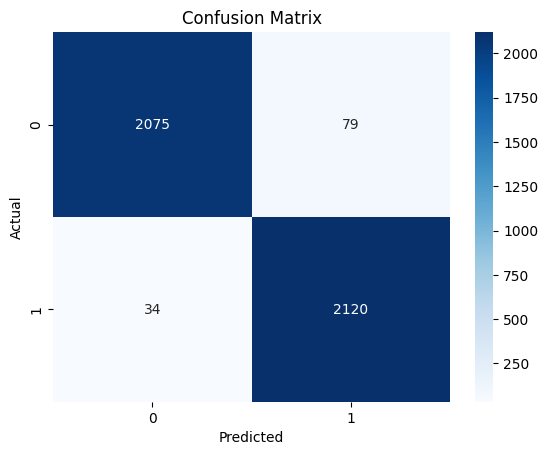

In [17]:
# === 혼동 행렬 시각화 ===
cm = confusion_matrix(y_sm, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
# === 테스트 데이터 예측 및 저장 ===
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({'ID': test_id, '허위매물여부': test_preds_binary})
submission.to_csv('/content/drive/MyDrive/DACON/2025/(202502) 부동산 허위매물 분류 해커톤: 가짜를 색출하라!/submission_0.84627_lgbm.csv', index=False)
print("Submission file saved to 'submission_0.84627_lgbm.csv'")

Submission file saved to 'submission_0.84627_lgbm.csv'
